<a href="https://colab.research.google.com/github/sainvo/DeepLearning_NER/blob/master/DL_NER_Adadelta70.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning NER task

Tatjana Cucic and Sanna Volanen

https://spacy.io/api/annotation

# Milestones

## 1.1 Predicting word labels independently

* The first part is to train a classifier which assigns a label for each given input word independently. 
* Evaluate the results on token level and entity level. 
* Report your results with different network hyperparameters. 
* Also discuss whether the token level accuracy is a reasonable metric.









In [1]:
# Training data: Used for training the model
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/train.tsv

# Development/ validation data: Used for testing different model parameters, for example level of regularization needed
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/dev.tsv

# Test data: Never touched during training / model development, used for evaluating the final model
!wget https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/test.tsv



--2020-05-11 17:09:40--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17252156 (16M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]  16.45M   101MB/s    in 0.2s    

2020-05-11 17:09:41 (101 MB/s) - ‘train.tsv’ saved [17252156/17252156]

--2020-05-11 17:09:42--  https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2419425 (2.3M) [text/plain]
Saving to: ‘dev.tsv

In [2]:
import sys 
import csv

csv.field_size_limit(sys.maxsize)

131072

In [3]:
#read tsv data to list of lists of lists: a list of sentences that contain lists of tokens that are lists of unsplit \t lines from the tsv, such as ['attract\tO']
token = {"word":"","entity_label":""}

def read_ontonotes(tsv_file): # 
    current_sent = [] # list of (word,label) lists
    with open(tsv_file) as f:
        tsvreader = csv.reader(f, delimiter= '\n')
        for line in tsvreader:
            #print(line)
            if not line:
                if current_sent:
                    yield current_sent
                    current_sent=[]
                continue
            current_sent.append(line) 
        else:
            if current_sent:
                yield current_sent

full_train_data = list(read_ontonotes('train.tsv'))
size_tr = int(len(full_train_data)/2)
print(size_tr)
##slice train
train_data_sample = full_train_data[:size_tr]
print(train_data_sample[:5])
print()
full_dev_data = list(read_ontonotes('dev.tsv'))
size_dv = int(len(full_dev_data)/2)
print(size_dv)
#slice dev
dev_data_sample = full_dev_data[:size_dv]
print(dev_data_sample[:5])
print()
full_test_data = list(read_ontonotes('test.tsv'))
size_ts = int(len(full_test_data)/2)
print(size_ts)
test_data_sample = full_test_data[:size_ts]

33409
[[['Big\tO'], ['Managers\tO'], ['on\tO'], ['Campus\tO']], [['In\tO'], ['recent\tB-DATE'], ['years\tI-DATE'], [',\tO'], ['advanced\tO'], ['education\tO'], ['for\tO'], ['professionals\tO'], ['has\tO'], ['become\tO'], ['a\tO'], ['hot\tO'], ['topic\tO'], ['in\tO'], ['the\tO'], ['business\tO'], ['community\tO'], ['.\tO']], [['With\tO'], ['this\tO'], ['trend\tO'], [',\tO'], ['suddenly\tO'], ['the\tO'], ['mature\tO'], ['faces\tO'], ['of\tO'], ['managers\tO'], ['boasting\tO'], ['an\tO'], ['average\tO'], ['of\tO'], ['over\tO'], ['ten\tB-DATE'], ['years\tI-DATE'], ['of\tO'], ['professional\tO'], ['experience\tO'], ['have\tO'], ['flooded\tO'], ['in\tO'], ['among\tO'], ['the\tO'], ['young\tO'], ['people\tO'], ['populating\tO'], ['university\tO'], ['campuses\tO'], ['.\tO']], [['In\tO'], ['order\tO'], ['to\tO'], ['attract\tO'], ['this\tO'], ['group\tO'], ['of\tO'], ['seasoned\tO'], ['adults\tO'], ['pulling\tO'], ['in\tO'], ['over\tO'], ['NT$\tB-MONEY'], ['1\tI-MONEY'], ['million\tI-MONEY'], ['

In [4]:
import re
#regex for empty space chars, \t \n
tab = re.compile('[\t]')

def clean(list):
    clean_data =[]
    for sent in list:
        clean_list = []
        for item in sent:
            str = ''.join(item)
            #match_nl = re.match(r"\n", str)
            #print(match_nl)
            count_tab =  re.findall(r"\t", str)
            #print(count_tab)
            if len(count_tab) == 1: 
                item = re.split("\t", str)
                if item[0] != '.':
                    clean_list.append(item)
            elif len(count_tab) > 1:
                item = re.split("\n", str)
                #print(item)
                for i in range(len(item)):
                    #print(item[i])
                    if i == 0 or i == len(item)-1:
                        item[i] = '"'+item[i]
                        item[i] = re.split("\t", item[i])
                        #print(item[i])
                    else:
                        item[i] = re.split("\t", item[i])
                        #print(item[i])
                    clean_list.append(item[i])
        clean_data.append(clean_list)        
    return clean_data

train_data_clean = clean(train_data_sample)
print(len(train_data_clean))
for item in train_data_clean[:3]:
    print(item)
print('------------------------------------------')
dev_data_clean = clean(dev_data_sample)
print(len(dev_data_clean))
for item in dev_data_clean[:3]:
    print(item)
print('------------------------------------------')
test_data_clean = clean(test_data_sample)
print(len(test_data_clean))
for item in test_data_clean[:3]:
    print(item)
print('------------------------------------------')          

33409
[['Big', 'O'], ['Managers', 'O'], ['on', 'O'], ['Campus', 'O']]
[['In', 'O'], ['recent', 'B-DATE'], ['years', 'I-DATE'], [',', 'O'], ['advanced', 'O'], ['education', 'O'], ['for', 'O'], ['professionals', 'O'], ['has', 'O'], ['become', 'O'], ['a', 'O'], ['hot', 'O'], ['topic', 'O'], ['in', 'O'], ['the', 'O'], ['business', 'O'], ['community', 'O']]
[['With', 'O'], ['this', 'O'], ['trend', 'O'], [',', 'O'], ['suddenly', 'O'], ['the', 'O'], ['mature', 'O'], ['faces', 'O'], ['of', 'O'], ['managers', 'O'], ['boasting', 'O'], ['an', 'O'], ['average', 'O'], ['of', 'O'], ['over', 'O'], ['ten', 'B-DATE'], ['years', 'I-DATE'], ['of', 'O'], ['professional', 'O'], ['experience', 'O'], ['have', 'O'], ['flooded', 'O'], ['in', 'O'], ['among', 'O'], ['the', 'O'], ['young', 'O'], ['people', 'O'], ['populating', 'O'], ['university', 'O'], ['campuses', 'O']]
------------------------------------------
5806
[['President', 'B-WORK_OF_ART'], ['Chen', 'I-WORK_OF_ART'], ['Travels', 'I-WORK_OF_ART'], ['Abr

In [5]:
# shape into dicts per sentence

def reshape_sent2dicts(f):
    data_dict = []
    for item in f: # list of lists (tokens)
        #print(item)
        sent_text= [] 
        sent_tags = []
        for token in item:
            if len(token) ==2:
                sent_text.append(token[0])
                sent_tags.append(token[1])
        sent_dict = {'text':sent_text,'tags':sent_tags }
        #print(sent_dict['text'])
        #print(sent_dict['tags'])
        data_dict.append(sent_dict)
    return data_dict

train_data_sent = list(reshape_sent2dicts(train_data_clean[:30000]))
samp = train_data_sent[:3]
print(samp)
print()
dev_data_sent = list(reshape_sent2dicts(dev_data_clean))
samp2 = dev_data_sent[:3]
print(samp2)

[{'text': ['Big', 'Managers', 'on', 'Campus'], 'tags': ['O', 'O', 'O', 'O']}, {'text': ['In', 'recent', 'years', ',', 'advanced', 'education', 'for', 'professionals', 'has', 'become', 'a', 'hot', 'topic', 'in', 'the', 'business', 'community'], 'tags': ['O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, {'text': ['With', 'this', 'trend', ',', 'suddenly', 'the', 'mature', 'faces', 'of', 'managers', 'boasting', 'an', 'average', 'of', 'over', 'ten', 'years', 'of', 'professional', 'experience', 'have', 'flooded', 'in', 'among', 'the', 'young', 'people', 'populating', 'university', 'campuses'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}]

[{'text': ['President', 'Chen', 'Travels', 'Abroad'], 'tags': ['B-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART', 'I-WORK_OF_ART']}, {'text': ['(', 'Chang', 'Chiung', '-', 'fang', '/', '

In [6]:
import random
import numpy

random.seed(123)
random.shuffle(train_data_sent)
print(type(train_data_sent))
print(type(train_data_sent[0]))

train_texts=[i["text"] for i in train_data_sent]
train_labels=[i["tags"] for i in train_data_sent]

#print(type(train_texts))
#print(type(train_texts[0]))

print('Text: ', train_texts[:4])
print('Labels: ', train_labels[:4])

<class 'list'>
<class 'dict'>
Text:  [['Sharon', 'Repudiates', 'the', 'Road', 'Map'], ['AppleScript', 'is', 'just', 'one', 'of', 'several', 'client', 'languages', 'for', 'these', 'services', '(', 'it', 'was', "n't", 'even', 'the', 'first', ',', 'btw', ';', 'UserTalk', 'predates', 'it', ')'], ['Your', 'qualifications', 'quote', 'end', 'quote', 'meaningless', '/.'], ['[dasanicool]', 'Young', 'people', 'like', 'to', 'race', 'high', '-', 'power', 'motorcycles', 'late', 'at', 'night', 'and', 'revel', 'in', 'bars', 'well', 'after', 'dark']]
Labels:  [['O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


In [0]:
## same for validation/dev data
dev_texts=[i["text"] for i in dev_data_sent]
dev_labels=[i["tags"] for i in dev_data_sent]

Let's add POS tags to the data

In [0]:
# DO NOT RUN
#import nltk
#nltk.download('averaged_perceptron_tagger') 

#def sent_parser4pos(texts, labels):
  #  for i in range(len(texts) -1):
#        #print(texts[i])
#        tokens_with_pos = nltk.pos_tag(texts[i])
#        #getting the corresponding labels list
 #       labels_curr= labels[i]
  #      print()
 #       print()
        #print('current labels:',labels_curr)
       #updating labels with pos label
        #print('possed tokens:', tokens_with_pos)
  #      for j in range(len(labels_curr) -1):
   #         bio = labels_curr[j]
  #          pos = tokens_with_pos[j][1]
            #print('bio: ',bio)
            #print('pos: ', pos)
            #print('current labels: ',labels[i])
   #         new_label = pos+' '+bio ## new kind of combination label
   #         labels[i][j] = new_label
        #print('No of Bio Labels: ',len(labels_curr), ' No of pos tags: ', len(tokens_with_pos), ' No of updated labels: ', len(labels[i]), labels[i])
  #  return labels

In [0]:
# DO NOT RUN
#train_labels_posbio = sent_parser4pos(train_texts, train_labels)
#print(train_texts[0])
#print(train_labels[0]
#print(train_labels_posbio[0])

In [10]:
# Load pretrained embeddings
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2020-05-11 17:09:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  21.9MB/s    in 30s     

2020-05-11 17:10:20 (21.5 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [11]:
# Give -n argument so that a possible existing file isn't overwritten 
!unzip -n wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [12]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("in")[:10])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [13]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


Preprocessing

In [14]:
#Labels
from pprint import pprint

not_letter = re.compile(r'[^a-zA-Z]')
# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences 
    #print(sentence_labels)
    for label in sentence_labels: #loops over labels in one sentence
       # match = not_letter.match(label)
        #if match or label== 'O':
        #    break
        #else:    
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-CARDINAL': 12,
 'B-DATE': 1,
 'B-EVENT': 21,
 'B-FAC': 25,
 'B-GPE': 29,
 'B-LANGUAGE': 27,
 'B-LAW': 23,
 'B-LOC': 17,
 'B-MONEY': 10,
 'B-NORP': 15,
 'B-ORDINAL': 18,
 'B-ORG': 8,
 'B-PERCENT': 33,
 'B-PERSON': 19,
 'B-PRODUCT': 7,
 'B-QUANTITY': 30,
 'B-TIME': 20,
 'B-WORK_OF_ART': 34,
 'I-CARDINAL': 28,
 'I-DATE': 31,
 'I-EVENT': 14,
 'I-FAC': 13,
 'I-GPE': 26,
 'I-LANGUAGE': 5,
 'I-LAW': 9,
 'I-LOC': 22,
 'I-MONEY': 11,
 'I-NORP': 0,
 'I-ORDINAL': 4,
 'I-ORG': 16,
 'I-PERCENT': 35,
 'I-PERSON': 3,
 'I-PRODUCT': 24,
 'I-QUANTITY': 2,
 'I-TIME': 36,
 'I-WORK_OF_ART': 32,
 'O': 6}


In [15]:
# vectorize the labels
def label_vectorizer(train_labels,label_map):
    vectorized_labels = []
    for label in train_labels:
        vectorized_example_label = []
        for token in label:
            if token in label_map:
                vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(train_labels,label_map)
validation_vectorized_labels = label_vectorizer(dev_labels,label_map)

pprint(vectorized_labels[0])

[6, 6, 6, 6, 6]


In [16]:
## vectorization of the texts
def text_vectorizer(vocab, train_texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(train_texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, dev_texts)

pprint(train_texts[0])
pprint(vectorized_data[0])

['Sharon', 'Repudiates', 'the', 'Road', 'Map']
[8346, 1, 3, 1685, 8936]


In [17]:
# padding for tensor
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences
print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='pre', maxlen=max(lengths))
print("New shape:", vectorized_data_padded.shape)
print("First example:")
print( vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=numpy.expand_dims(pad_sequences(vectorized_labels, padding='pre', maxlen=max(lengths)), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
pprint(label_map)
print("First example labels:")
pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:")
print( weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='pre', maxlen=max(lengths))
validation_vectorized_labels_padded=numpy.expand_dims(pad_sequences(validation_vectorized_labels, padding='pre',maxlen=max(lengths)), -1)
validation_weights = numpy.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

Using TensorFlow backend.


Old shape: (30000,)
New shape: (30000, 17040)
First example:
[   0    0    0 ...    3 1685 8936]
Padded labels shape: (30000, 17040, 1)
{'B-CARDINAL': 12,
 'B-DATE': 1,
 'B-EVENT': 21,
 'B-FAC': 25,
 'B-GPE': 29,
 'B-LANGUAGE': 27,
 'B-LAW': 23,
 'B-LOC': 17,
 'B-MONEY': 10,
 'B-NORP': 15,
 'B-ORDINAL': 18,
 'B-ORG': 8,
 'B-PERCENT': 33,
 'B-PERSON': 19,
 'B-PRODUCT': 7,
 'B-QUANTITY': 30,
 'B-TIME': 20,
 'B-WORK_OF_ART': 34,
 'I-CARDINAL': 28,
 'I-DATE': 31,
 'I-EVENT': 14,
 'I-FAC': 13,
 'I-GPE': 26,
 'I-LANGUAGE': 5,
 'I-LAW': 9,
 'I-LOC': 22,
 'I-MONEY': 11,
 'I-NORP': 0,
 'I-ORDINAL': 4,
 'I-ORG': 16,
 'I-PERCENT': 35,
 'I-PERSON': 3,
 'I-PRODUCT': 24,
 'I-QUANTITY': 2,
 'I-TIME': 36,
 'I-WORK_OF_ART': 32,
 'O': 6}
First example labels:
array([[0],
       [0],
       [0],
       ...,
       [6],
       [6],
       [6]], dtype=int32)
First weight vector:
[0 0 0 ... 1 1 1]


In [0]:
# Evaluation function
import keras

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [0]:
# model 1
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam, Adamax, Adadelta, Adagrad, Nadam 

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 50

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="relu"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [20]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17040)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 17040, 300)        15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17040, 50)         15050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17040, 37)         1887      
Total params: 15,017,537
Trainable params: 16,937
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [21]:
# train the model 1
optimizer=Adam(lr=0.05) # define the learning rate
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10
 - 48s - loss: 5.2882e-04

Precision/Recall/F-score: 0.44780793319415446 / 0.061655648174762864 / 0.10838807478524508
Epoch 2/10
 - 47s - loss: 3.4230e-04

Precision/Recall/F-score: 0.452947259565667 / 0.06294912331129635 / 0.11053627760252366
Epoch 3/10
 - 47s - loss: 3.2457e-04

Precision/Recall/F-score: 0.4349056603773585 / 0.06625467088243749 / 0.11499126964330257
Epoch 4/10
 - 47s - loss: 3.1840e-04

Precision/Recall/F-score: 0.4005708848715509 / 0.06050589249784421 / 0.10513172680734174
Epoch 5/10
 - 47s - loss: 3.1577e-04

Precision/Recall/F-score: 0.4223175965665236 / 0.07070997413049727 / 0.12113751077188231
Epoch 6/10
 - 47s - loss: 3.0668e-04

Precision/Recall/F-score: 0.420584498094028 / 0.04757114113250934 / 0.08547449967721112
Epoch 7/10
 - 47s - loss: 3.0876e-04

Precision/Recall/F-score: 0.43890020366598775 / 0.06194308709399253 / 0.10856423173803527
Epoch 8/10
 - 47s - loss: 3.0973e-04

Precision/Recall/F-score: 0.4293193717277487 / 0.058924978442081055 / 0.

No handles with labels found to put in legend.


History: [0.10838807478524508, 0.11053627760252366, 0.11499126964330257, 0.10513172680734174, 0.12113751077188231, 0.08547449967721112, 0.10856423173803527, 0.10362694300518134, 0.09315491507977354, 0.1254720428797661]
Highest f-score: 0.1254720428797661


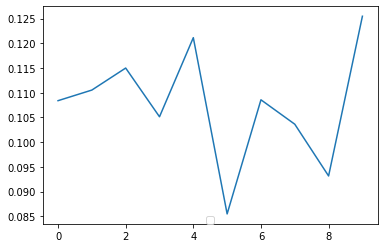

In [22]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores):
    print("History:", fscores)
    print("Highest f-score:", max(fscores))
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

In [0]:
# model 2
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam, Adamax, Adadelta, Adagrad, Nadam 

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 50

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="sigmoid"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model2 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [24]:
# train the model 2
optimizer=Adamax(lr=0.01) # define the learning rate
model2.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model2.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10
 - 47s - loss: 7.8312e-04

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Epoch 2/10
 - 47s - loss: 5.2328e-04

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Epoch 3/10
 - 47s - loss: 4.7204e-04

Precision/Recall/F-score: 0.45390070921985815 / 0.009198045415349238 / 0.01803070855050007
Epoch 4/10
 - 47s - loss: 4.3499e-04

Precision/Recall/F-score: 0.32142857142857145 / 0.016815176774935325 / 0.03195848128926523
Epoch 5/10
 - 47s - loss: 4.0892e-04

Precision/Recall/F-score: 0.324853228962818 / 0.023857430296062087 / 0.04445039496585889
Epoch 6/10
 - 47s - loss: 3.8950e-04

Precision/Recall/F-score: 0.36942675159235666 / 0.03334291463064099 / 0.06116530450830478
Epoch 7/10
 - 47s - loss: 3.7667e-04

Precision/Recall/F-score: 0.34375 / 0.03794193733831561 / 0.06834066787470876
Epoch 8/10
 - 47s - loss: 3.6598e-04

Precision/Recall/F-score: 0.3524804177545692 / 0.038804254096004596 / 0.0699119627136199
Epoch 9/10
 - 47s - loss: 3.5805e-04

Precision/Recall/F-score: 0.3679890560875513 /

No handles with labels found to put in legend.


History: [0.0, 0.0, 0.01803070855050007, 0.03195848128926523, 0.04445039496585889, 0.06116530450830478, 0.06834066787470876, 0.0699119627136199, 0.06997008713746912, 0.09027513630024091]
Highest f-score: 0.09027513630024091


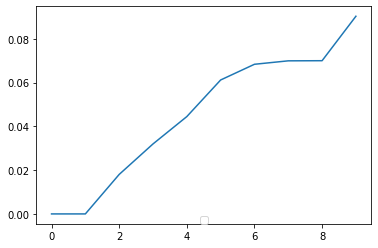

In [25]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores):
    print("History:", fscores)
    print("Highest f-score:", max(fscores))
    plt.plot(fscores)
    plt.legend(loc='lower center', borderaxespad=0.)
    plt.show()

plot_history(evaluation_function.fscore)

In [0]:
# model 3
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam, Adamax, Adadelta, Adagrad, Nadam 

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 50

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="sigmoid"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model3 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

In [27]:
# train the model 3
optimizer=Adadelta(lr=0.01) # define the learning rate
model3.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()

# train
vanilla_hist=model3.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10
 - 47s - loss: 0.0049

Precision/Recall/F-score: 0.6892132431470274 / 0.8347226214429434 / 0.7550211244718881
Epoch 2/10
 - 47s - loss: 0.0049

Precision/Recall/F-score: 0.6832137395600517 / 0.8347226214429434 / 0.751406947409276
Epoch 3/10
 - 47s - loss: 0.0048

Precision/Recall/F-score: 0.6795366795366795 / 0.8347226214429434 / 0.7491776846178652
Epoch 4/10
 - 47s - loss: 0.0048

Precision/Recall/F-score: 0.6730791516977633 / 0.8347226214429434 / 0.7452364149611855
Epoch 5/10
 - 47s - loss: 0.0047

Precision/Recall/F-score: 0.6615787675133842 / 0.8347226214429434 / 0.7381330622100781
Epoch 6/10
 - 47s - loss: 0.0047

Precision/Recall/F-score: 0.6523643715601483 / 0.8347226214429434 / 0.73236239833554
Epoch 7/10
 - 47s - loss: 0.0046

Precision/Recall/F-score: 0.6464106844741235 / 0.8347226214429434 / 0.7285956219030295
Epoch 8/10
 - 47s - loss: 0.0046

Precision/Recall/F-score: 0.6283674131775397 / 0.8347226214429434 / 0.7169927782235664
Epoch 9/10
 - 47s - loss: 0.0046

P

## 1.2 Expand context

Modify your network in such way that it is able to utilize the surrounding context of the word. This can be done for instance with a convolutional or recurrent layer. Analyze different neural network architectures and hyperparameters. How does utilizing the surrounding context influence the predictions?


In [0]:
#expanding to RNN model with context

from keras.layers import LSTM

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 100

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=False, trainable=False, weights=[pretrained])(inp)
    rnn = LSTM(rnn_size, activation='relu', return_sequences=True)(embeddings)
    outp=Dense(class_count, activation="softmax")(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [29]:

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17040)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 17040, 300)        15000600  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17040, 50)         15050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17040, 37)         1887      
Total params: 15,017,537
Trainable params: 16,937
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [0]:

optimizer=Adam(lr=0.01) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function])

Epoch 1/10


In [0]:

%matplotlib inline

plot_history(evaluation_function.fscore)

## 2.1 Use deep contextual representations

Use deep contextual representations. Fine-tune the embeddings with different hyperparameters. Try different models (e.g. cased and uncased, multilingual BERT). Report your results.


## 2.2 Error analysis

Select one model from each of the previous milestones (three models in total). Look at the entities these models predict. Analyze the errors made. Are there any patterns? How do the errors one model makes differ from those made by another?

## 3.1 Predictions on unannotated text

Use the three models selected in milestone 2.2 to do predictions on the sampled wikipedia text.

## 3.2 Statistically analyze the results

Statistically analyze (i.e. count the number of instances) and compare the predictions. You can, for example, analyze if some models tend to predict more entities starting with a capital letter, or if some models predict more entities for some specific classes than others.